2020-10-29 16:01:53 INFO main [xml.cpp:1221] Loading XML file "corntest.xml" ..

2020-10-29 16:01:53 INFO main [xml.cpp:1222] Using variant "scalar_rgb"

2020-10-29 16:01:53 INFO main [xml.cpp:355] "corntest.xml": in-memory version upgrade (v2.0.0 -> v2.2.1) ..

2020-10-29 16:01:53 INFO main [PluginManager] Loading plugin "plugins/obj.dylib" ..

2020-10-29 16:01:53 INFO main [ShapeKDTree] Building a SAH kd-tree (91 primitives) ..

2020-10-29 16:01:53 INFO main [ShapeKDTree] Finished. (3.8 KiB of storage, took 12ms)

2020-10-29 16:01:53 INFO main [SamplingIntegrator] Starting render job (768x576, 16 samples, 4 threads)

2020-10-29 16:01:55 INFO main [SamplingIntegrator] Rendering finished. (took 1.667s)

2020-10-29 16:01:55 INFO main [SamplingIntegrator] Starting render job (100x100, 16 samples, 4 threads)

2020-10-29 16:01:55 INFO main [SamplingIntegrator] Rendering finished. (took 304ms)

2020-10-29 16:01:55 INFO main [HDRFilm] ✔ Developing "camera_output.exr" ..

Total illumination on object is 278.5502624511719.


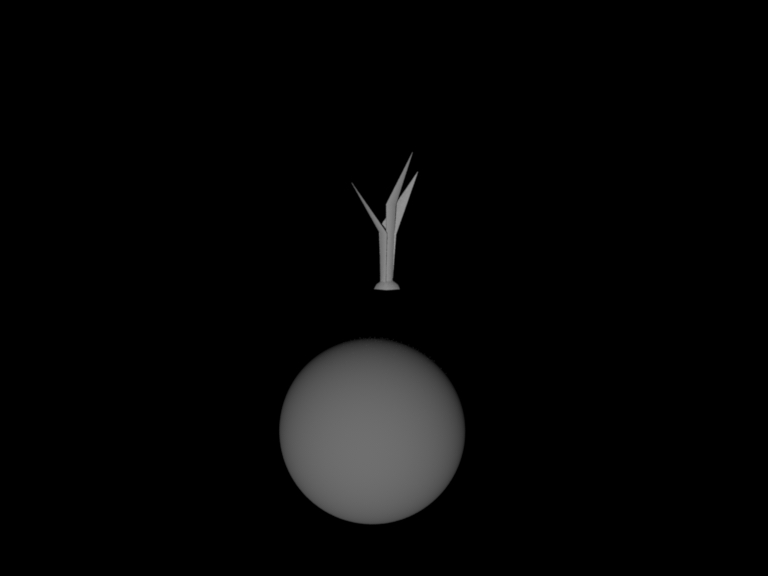

In [4]:
# An old notebook for testing the interface between Python and Mitsuba
# Has code for rendering scene as image and also for extracting irradiance values


import os
import numpy as np
import mitsuba

# Set the desired mitsuba variant
mitsuba.set_variant('scalar_rgb')

from mitsuba.core import Bitmap, Struct, Thread
from mitsuba.core.xml import load_file

# Allow embedding of rendered images in this notebook
from IPython.display import Image

# Absolute or relative path to the XML file
filename = 'corntest.xml'

# Add the scene directory to the FileResolver's search path
Thread.thread().file_resolver().append(os.path.dirname(filename))

# Load the actual scene
scene = load_file(filename)

# Call the scene's integrator to render the loaded scene
# index corresponds to the order of sensors in the scene file:
CAMERA = 0
RADMETER = 1
scene.integrator().render(scene, scene.sensors()[CAMERA])

# After rendering, the rendered data is stored in the film
film = scene.sensors()[CAMERA].film()

# call the integrator again for the radmeter, and store its "film" output
scene.integrator().render(scene, scene.sensors()[RADMETER])
meter = scene.sensors()[RADMETER].film()

# Write out rendering as high dynamic range OpenEXR file
film.set_destination_file('camera_output.exr')
film.develop()

# Write out a tonemapped JPG of the same rendering
bmp = film.bitmap(raw=True)
bmp.convert(Bitmap.PixelFormat.RGB, Struct.Type.UInt8, srgb_gamma=True).write('camera_output.jpg')

# Get linear pixel values from the irradiance meter as a numpy array for further processing
# pixel format specified as 'Y' should yield luminance-only values
rad = meter.bitmap(raw=True)
rad_linear_Y = rad.convert(Bitmap.PixelFormat.Y, Struct.Type.Float32, srgb_gamma=False)
rad_np = np.array(rad_linear_Y)

# outputs for testing/debugging
# numpy.savetxt requires 1D or 2D array, hence taking a slice (an RGB image is a 3D array)
#print(rad_np.shape)
#print(rad_np)
#np.savetxt('output.txt', rad_np[:,:,0])
print("Total illumination on object is {}.".format(np.sum(rad_np)) )

# show camera output of scene
Image(filename='camera_output.jpg') 
